Задание для самостоятельной работы №2
Цель работы: Развить навыки работы с NumPy, Pandas и Matplotlib для анализа данных.

Задание: Создать программу, которая загружает CSV-файл из открытых источников, выполняет анализ данных.
Входные данные: Скачайте CSV-файл из открытых источников (например, Kaggle, UCI Repository). Файл должен содержать минимум 5 колонок, включая числовые, категориальные и временные данные.

Требования:
Загрузить CSV-файл с помощью Pandas.
Выполнить предварительную обработку:
Обработать пропущенные значения, определить возможность замены и заменить одним из известных вам способов.
По необходимости провести преобразование временных данных.
     3. Реализовать функции:
Подсчет уникальных значений.
Расчет корреляции между двумя числовыми колонками.
Фильтрация данных по нескольким критериям (например, числовое значение и категория).
Группировка данных с вычислением статистики (среднее, стандартное отклонение).
     4. Создать:
График временного хода.
Диаграмма рассеяния с цветовым разделением по категориям.
Коробчатая диаграмма.
     5. Программа должна быть написана в объектно-ориентированном стиле.
     6. Вывести результаты в консоль и сохранить графики в файл.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import wraps
from datetime import datetime

In [2]:
def safe_execute(default_return=None, log_error=True):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except Exception as e:
                if log_error:
                    print(f"Ошибка в '{func.__name__}': {str(e)}")
                return default_return
        return wrapper
    return decorator


In [3]:
class DataLoader:
    COLUMNS_TO_LOAD = [
        'screen_time_hours',
        'stress_level_0_10',
        'mental_wellness_index_0_100',
        'occupation',
        'age',
        'gender',
        'timestamp']

    @safe_execute(default_return=None)
    def __init__(self, csv_path="ScreenTime_vs_MentalWellness.csv"):
        self.csv_path = csv_path
        # 👇 ОБЯЗАТЕЛЬНО: вызываем load_data и сохраняем результат в self.df
        self.df = self.load_data()
        # 👇 ОБЯЗАТЕЛЬНО: вызываем обработку пропусков
        self.handle_missing_values()
        print("✅ DataLoader: данные загружены и обработаны.")

    @safe_execute(default_return=pd.DataFrame())
    def load_data(self):
        """Загружает только нужные колонки, удаляет строки с пустым timestamp, сортирует по времени."""
        df = pd.read_csv(self.csv_path, usecols=self.COLUMNS_TO_LOAD)
        
        # 🔍 Выводим тип данных timestamp ДО преобразования
        print(f"🔍 Тип данных в 'timestamp' ДО преобразования: {df['timestamp'].dtype}")
        
        # Преобразуем в datetime (на всякий случай)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # ✅ Выводим тип данных timestamp ПОСЛЕ преобразования (опционально, для сравнения)
        print(f"✅ Тип данных в 'timestamp' ПОСЛЕ преобразования: {df['timestamp'].dtype}")
    
        # Удаляем строки, где timestamp пустой
        initial_count = len(df)
        df = df.dropna(subset=['timestamp'])
        removed_count = initial_count - len(df)
        if removed_count > 0:
            print(f"🧹 Удалено {removed_count} строк(и) с пустым timestamp.")
        else:
            print("✅ Пустых значений в timestamp не обнаружено.")
    
        # Сортируем по времени
        df = df.sort_values('timestamp').reset_index(drop=True)
    
        return df

    @safe_execute(default_return=pd.DataFrame())
    def handle_missing_values(self):
        """Обрабатываю пропущенные значения: сначала удаляю строки с пустым timestamp, затем заполняю остальные."""
        print("\n🔍 Пропущенные значения ДО обработки:")
        print(self.df.isnull().sum())
    
        # ✂️ УДАЛЯЕМ строки, где timestamp пустой (NaN или NaT)
        initial_count = len(self.df)  # ← Было df — исправлено на self.df
        self.df = self.df.dropna(subset=['timestamp'])  # ← Было df — исправлено
        removed_count = initial_count - len(self.df)
        if removed_count > 0:
            print(f"🧹 Удалено {removed_count} строк(и) с пустым timestamp.")
        else:
            print("✅ Пустых значений в timestamp не обнаружено.")
    
        # 🧮 Заполняем пропуски в числовых колонках — медианой
        num_cols = self.df.select_dtypes(include=[np.number]).columns
        self.df[num_cols] = self.df[num_cols].fillna(self.df[num_cols].median())
    
        # 🧮 Заполняем пропуски в категориальных колонках — модой
        cat_cols = self.df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            if self.df[col].isnull().any():
                mode_val = self.df[col].mode()
                if not mode_val.empty:
                    self.df[col] = self.df[col].fillna(mode_val[0])
    
        print("\n✅ Пропущенные значения ПОСЛЕ обработки:")
        print(self.df.isnull().sum())
        return self.df


In [5]:
# Создаём загрузчик
loader = DataLoader()

# Получаем готовый DataFrame
df = loader.df

# Настройка отображения — чтобы колонки не переносились
pd.set_option('display.max_columns', None)      # Показывать все колонки
pd.set_option('display.width', None)            # Автоширина
pd.set_option('display.expand_frame_repr', False)  # Не переносить таблицу

# Получаем статистику
stats = df.describe(include='all').T  # .T — транспонируем для удобного чтения

# Красивый вывод в Jupyter
from IPython.display import display

display(stats.style
    .format(precision=2)  # Округляем до 2 знаков
    .set_properties(**{'text-align': 'center'})  # Центрируем текст
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]
    }])
    .set_caption(" Сводная статистика по датасету")
)

🔍 Тип данных в 'timestamp' ДО преобразования: object
✅ Тип данных в 'timestamp' ПОСЛЕ преобразования: datetime64[ns]
🧹 Удалено 1 строк(и) с пустым timestamp.

🔍 Пропущенные значения ДО обработки:
age                            1
gender                         1
occupation                     1
screen_time_hours              3
stress_level_0_10              0
mental_wellness_index_0_100    0
timestamp                      0
dtype: int64
✅ Пустых значений в timestamp не обнаружено.

✅ Пропущенные значения ПОСЛЕ обработки:
age                            0
gender                         0
occupation                     0
screen_time_hours              0
stress_level_0_10              0
mental_wellness_index_0_100    0
timestamp                      0
dtype: int64
✅ DataLoader: данные загружены и обработаны.


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
age,399.00,nan,nan,nan,29.77,16.00,24.00,30.00,35.00,60.00,7.47
gender,399,3,Female,223,nan,nan,nan,nan,nan,nan,nan
occupation,399,5,Employed,208,nan,nan,nan,nan,nan,nan,nan
screen_time_hours,399.00,nan,nan,nan,9.02,1.00,7.39,9.07,10.48,19.17,2.49
stress_level_0_10,399.00,nan,nan,nan,8.17,0.00,6.90,8.80,10.00,10.00,2.07
mental_wellness_index_0_100,399.00,nan,nan,nan,20.16,0.00,3.65,14.80,30.60,97.00,20.13
timestamp,399,nan,nan,nan,2025-08-23 18:54:55.639097600,2025-07-24 21:16:00,2025-08-07 19:43:00,2025-08-25 08:35:00,2025-09-08 05:29:00,2025-09-22 13:39:00,nan


     3. Реализовать функции:

Подсчет уникальных значений.
Расчет корреляции между двумя числовыми колонками.
Фильтрация данных по нескольким критериям (например, числовое значение и категория).
Группировка данных с вычислением статистики (среднее, стандартное отклонение).

In [56]:
import pandas as pd
from functools import wraps

def safe_execute(default_return=None):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except Exception as e:
                print(f"❌ Ошибка в '{func.__name__}': {e}")
                return default_return
        return wrapper
    return decorator


class DataAnalyzer:
    """
    Класс для анализа данных: уникальные значения, корреляции, фильтрация, группировка.
    """

    def __init__(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Ожидается pandas.DataFrame")
        self.df = df.copy()
        print("✅ DataAnalyzer инициализирован.")

    @safe_execute(default_return=None)
    def count_unique_values(self, column):
        if column not in self.df.columns:
            raise ValueError(f"Колонка '{column}' не найдена в DataFrame.")

        unique_counts = self.df[column].value_counts()
        print(f"\n🔢 Уникальные значения в '{column}':")
        print(unique_counts.to_string())
        print(f"→ Всего уникальных значений: {self.df[column].nunique()}\n")
        return unique_counts

    @safe_execute(default_return=None)
    def calculate_correlation(self, col1, col2, method='pearson'):
        for col in [col1, col2]:
            if col not in self.df.columns:
                raise ValueError(f"Колонка '{col}' не найдена.")
            if not pd.api.types.is_numeric_dtype(self.df[col]):
                raise TypeError(f"Колонка '{col}' должна быть числовой.")

        corr = self.df[col1].corr(self.df[col2], method=method)
        print(f"\n🔗 Корреляция ({method}) между '{col1}' и '{col2}': {corr:.4f}\n")
        return corr

    @safe_execute(default_return=None)
    def filter_data(self, filters):
        df_filtered = self.df.copy()

        for col, condition in filters.items():
            if col not in df_filtered.columns:
                raise ValueError(f"Колонка '{col}' не найдена.")

            if isinstance(condition, tuple) and len(condition) == 2:
                # 🔥 ИСПРАВЛЕНО: используем .between() для безопасной фильтрации
                df_filtered = df_filtered[
                    df_filtered[col].between(condition[0], condition[1], inclusive='both')
                ]
            elif isinstance(condition, str) and any(
                condition.startswith(op) for op in ('>', '<', '==', '!=')
            ):
                try:
                    if condition.startswith('>'):
                        val = float(condition[1:])
                        df_filtered = df_filtered[df_filtered[col] > val]
                    elif condition.startswith('<'):
                        val = float(condition[1:])
                        df_filtered = df_filtered[df_filtered[col] < val]
                    elif condition.startswith('=='):
                        val = float(condition[2:])
                        df_filtered = df_filtered[df_filtered[col] == val]
                    elif condition.startswith('!='):
                        val = float(condition[2:])
                        df_filtered = df_filtered[df_filtered[col] != val]
                except Exception as e:
                    raise ValueError(f"Некорректное условие для '{col}': {condition}") from e
            else:
                df_filtered = df_filtered[df_filtered[col] == condition]

        print(f"\n✅ Применены фильтры: {filters}")
        print(f"📊 Осталось строк: {len(df_filtered)} из {len(self.df)}\n")
        return df_filtered

    @safe_execute(default_return=None)
    def group_and_aggregate(self, group_col, agg_col, stats=['mean', 'std']):
        if group_col not in self.df.columns:
            raise ValueError(f"Колонка группировки '{group_col}' не найдена.")
        if agg_col not in self.df.columns:
            raise ValueError(f"Агрегируемая колонка '{agg_col}' не найдена.")
        result = self.df.groupby(group_col)[agg_col].agg(stats).round(3)
        print(f"\n Группировка по '{group_col}' → статистика по '{agg_col}':")
        return result

In [54]:
analyzer = DataAnalyzer(df)

# 1. Уникальные значения
analyzer.count_unique_values('gender')

# 2. Корреляция
analyzer.calculate_correlation('screen_time_hours', 'stress_level_0_10')

# 3. Фильтрация — ОБРАТИТЕ ВНИМАНИЕ: кортеж (25, 40), не список и не распаковка!
filtered_df = analyzer.filter_data({
    'age': (25, 40),           # ← кортеж, не список!
    'gender': 'Female',
    'stress_level_0_10': '>5'
})

analyzer.group_and_aggregate(
    group_col='occupation',
    agg_col='stress_level_0_10',
    stats=['mean', 'std', 'count']
)

✅ DataAnalyzer инициализирован.

🔢 Уникальные значения в 'gender':
gender
Female              223
Male                168
Non-binary/Other      8
→ Всего уникальных значений: 3


🔗 Корреляция (pearson) между 'screen_time_hours' и 'stress_level_0_10': 0.6970


✅ Применены фильтры: {'age': (25, 40), 'gender': 'Female', 'stress_level_0_10': '>5'}
📊 Осталось строк: 137 из 399


🧮 Группировка по 'occupation' → статистика по 'stress_level_0_10':
                mean    std  count
occupation                        
Employed       8.214  1.978    208
Retired        6.636  2.546     14
Self-employed  7.953  2.152     45
Student        8.801  1.799    106
Unemployed     6.400  2.112     26 



,mean,std,count
occupation,,,
Employed,8.214,1.978,208
Retired,6.636,2.546,14
Self-employed,7.953,2.152,45
Student,8.801,1.799,106
Unemployed,6.400,2.112,26


In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

class Visualizer:
    def __init__(self, df):
        self.df = df
        print("Visualizer")
        # Устанавливаем стиль по умолчанию для всех графиков
        plt.style.use('seaborn-v0_8')  # или 'ggplot', 'default'

    @safe_execute(default_return=None)
    def plot_time_series(self, column, title_suffix="", agg_freq=None):
        """
        Универсальный метод для построения временного ряда.
        
        Параметры:
        - column: имя колонки для отображения
        - title_suffix: дополнительный текст в заголовке
        - agg_freq: частота агрегации (например: 'h', 'D', 'W', 'M') — регистр важен!
                    'W' должно быть заглавным, иначе Pandas выдаст FutureWarning.
                    Если None — отображаются сырые данные.
        """
        plt.figure(figsize=(14, 6))
    
        if agg_freq is not None:
            # Просто используем то, что передал пользователь — без преобразований
            df_ts = self.df.set_index('timestamp').sort_index()
            
            try:
                data = df_ts[column].resample(agg_freq).mean()
            except ValueError as e:
                raise ValueError(f"Некорректная частота '{agg_freq}'. Поддерживаемые: 'h', 'D', 'W', 'M' и др. См. документацию Pandas.") from e
    
            x = data.index
            y = data.values
    
            # Настройка подписей оси X
            if agg_freq == 'h':  # часы
                xlabel = 'Дата и время'
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
                plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
            elif agg_freq in ['D', 'W', 'M']:  # день, неделя, месяц
                xlabel = 'Дата'
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                if agg_freq == 'W':
                    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
                else:
                    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
            else:
                xlabel = 'Дата и время'  # для прочих частот — оставляем общую подпись
        else:
            # Сырые данные
            x = self.df['timestamp']
            y = self.df[column]
            xlabel = 'Дата и время'
            if (x.max() - x.min()).days > 7:
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
            else:
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    
        # Построение графика
        marker = 'o' if len(x) < 100 else '.'
        plt.plot(x, y, marker=marker, linestyle='-', linewidth=2, alpha=0.8, color='#2E86AB')
    
        # Заголовок
        freq_label = agg_freq if agg_freq else "Сырые данные"
        plt.title(f'Временной ряд ({freq_label}): {column} {title_suffix}',
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(column, fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    @safe_execute(default_return=None)
    def plot_scatter_by_category(self, x_col, y_col, category_col='gender', title_suffix=""):
        """Выводит диаграмму рассеяния с цветовой категоризацией."""
        plt.figure(figsize=(10, 6))
        categories = self.df[category_col].unique()
        colors = plt.cm.Set1(np.linspace(0, 1, len(categories)))

        for i, cat in enumerate(categories):
            subset = self.df[self.df[category_col] == cat]
            plt.scatter(subset[x_col], subset[y_col], 
                       label=cat, alpha=0.7, s=60, color=colors[i], edgecolors='w', linewidth=0.5)

        plt.title(f'Диаграмма рассеяния: {x_col} vs {y_col} {title_suffix}', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(x_col, fontsize=12)
        plt.ylabel(y_col, fontsize=12)
        plt.legend(title=category_col, title_fontsize=12, fontsize=11, frameon=True, shadow=True)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    @safe_execute(default_return=None)
    def plot_boxplot(self, value_col='stress_level_0_10', category_col='occupation', title_suffix=""):
        """Выводит коробчатую диаграмму по категориям."""
        plt.figure(figsize=(12, 7))
        self.df.boxplot(column=value_col, by=category_col, grid=True, 
                       patch_artist=True,  # позволяет красить "коробки"
                       boxprops=dict(facecolor='#A23B72', color='black'),
                       medianprops=dict(color='white', linewidth=2),
                       whiskerprops=dict(color='black'),
                       capprops=dict(color='black'),
                       flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))

        plt.title(f'Коробчатая диаграмма: {value_col} по {category_col} {title_suffix}', 
                  fontsize=16, fontweight='bold')
        plt.suptitle('')  # Убираем автоматический заголовок "Boxplot grouped by..."
        plt.xlabel(category_col, fontsize=12)
        plt.ylabel(value_col, fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Visualizer


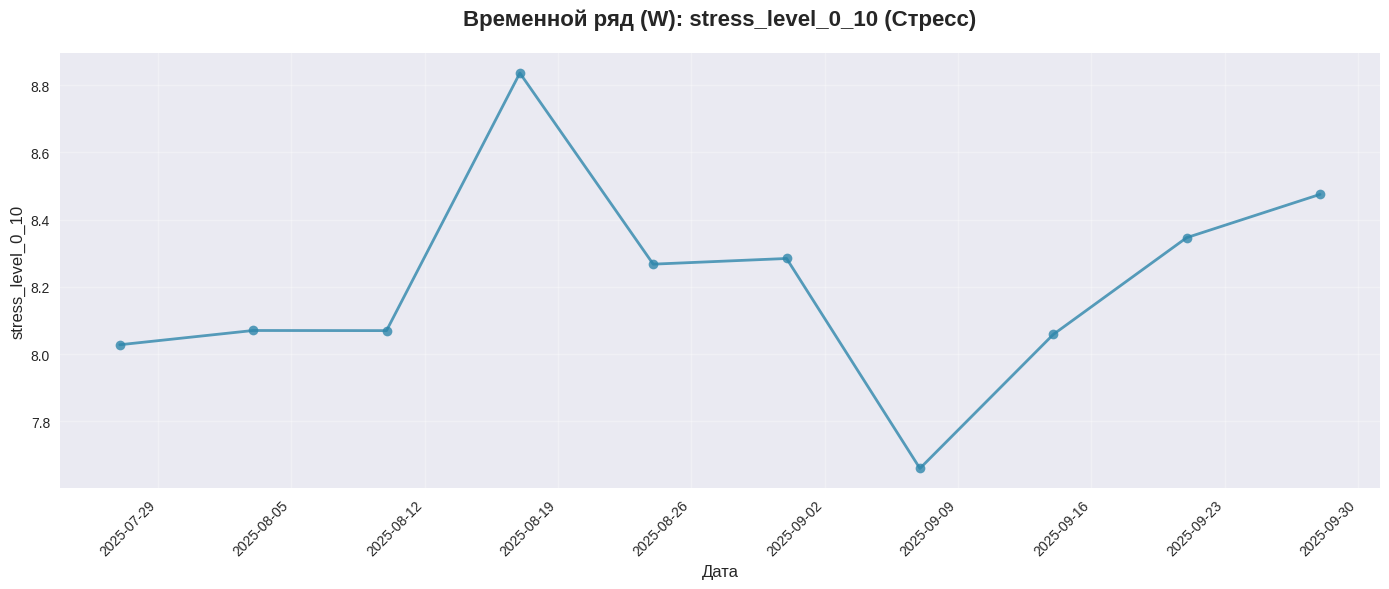

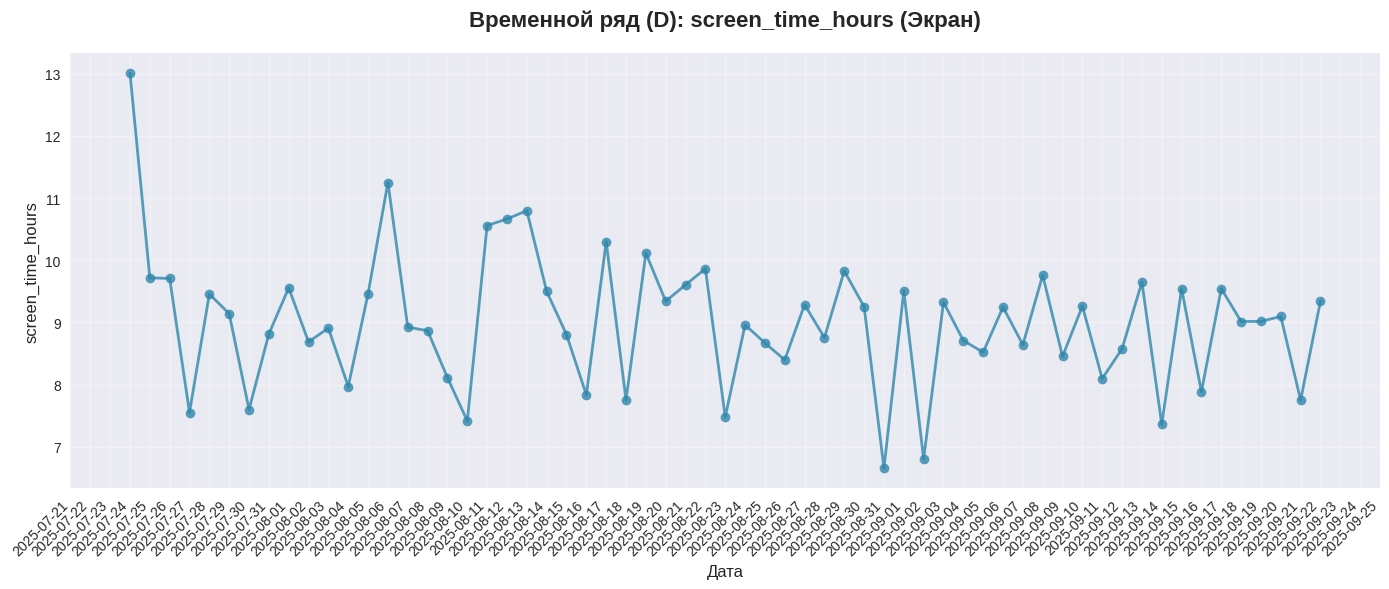

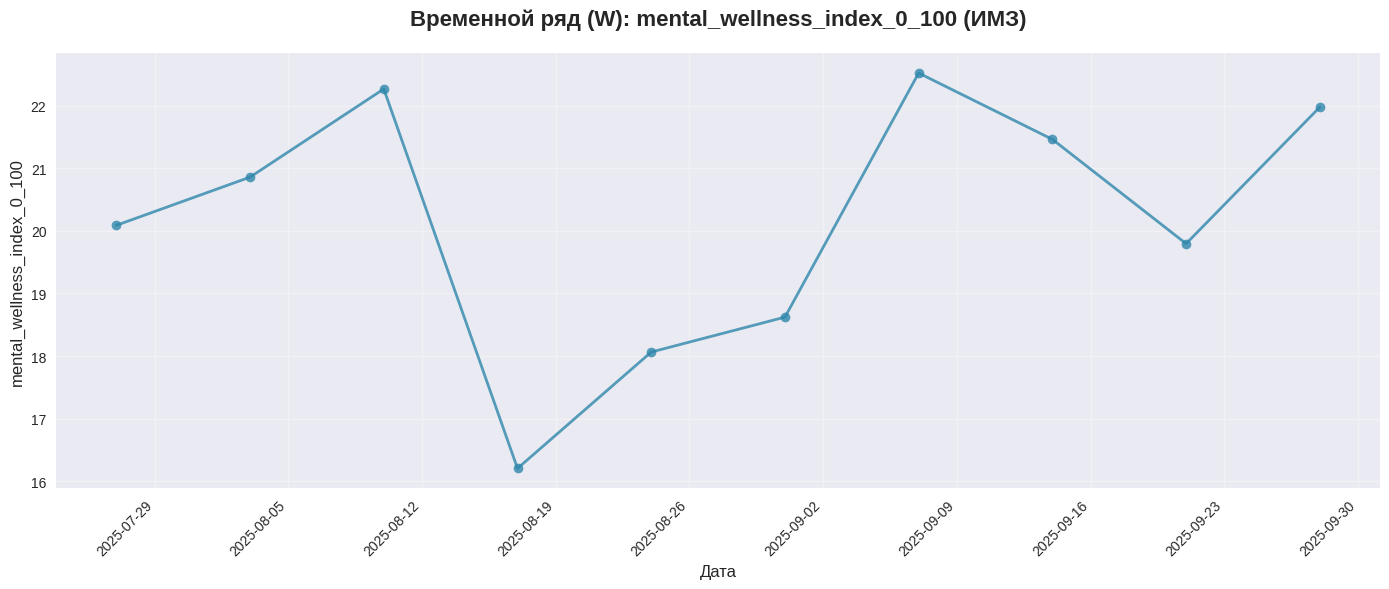

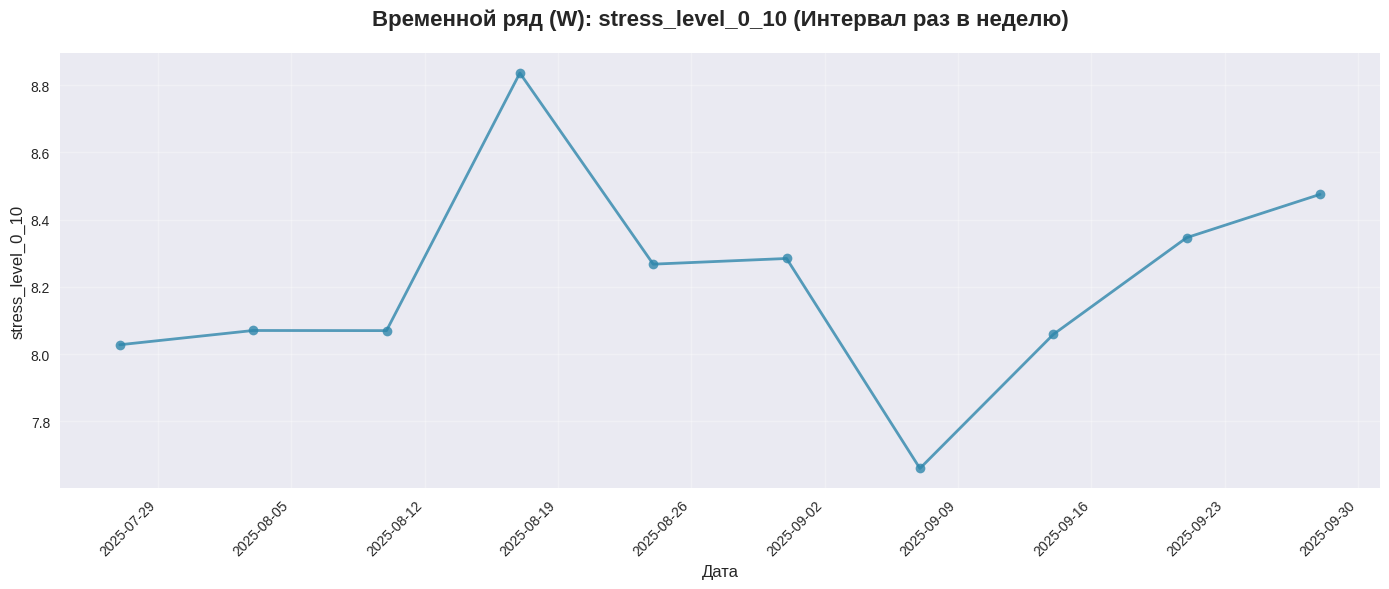

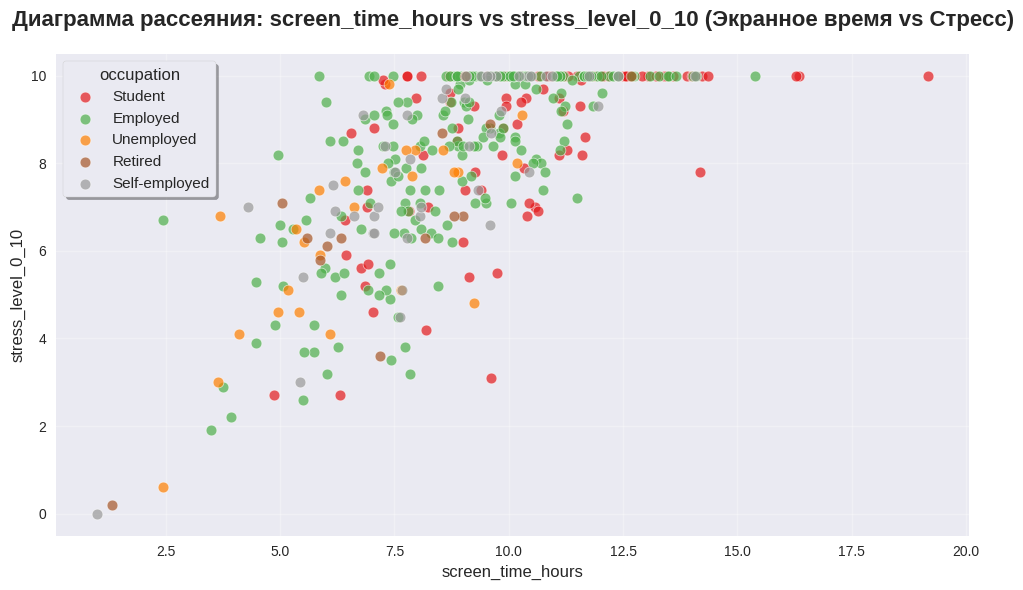

<Figure size 1200x700 with 0 Axes>

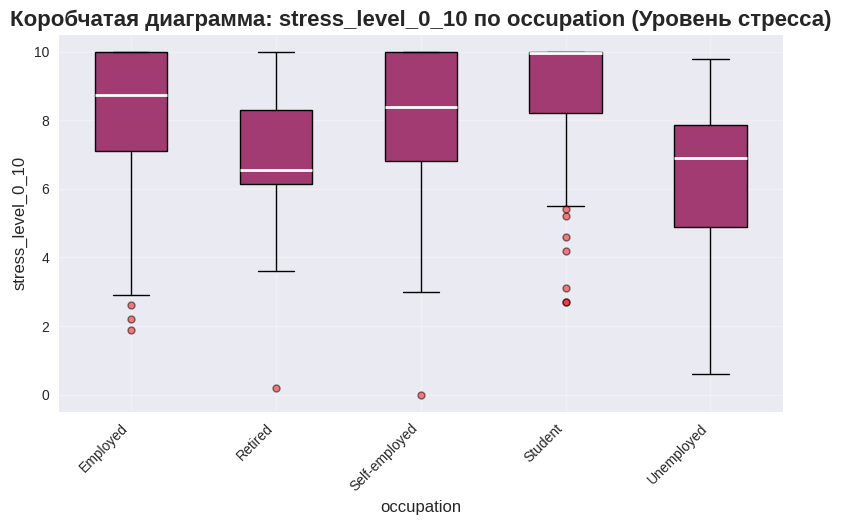

In [40]:
viz = Visualizer(df)

viz.plot_time_series('stress_level_0_10', "(Стресс)", 'W')
viz.plot_time_series('screen_time_hours', "(Экран)", 'D')
viz.plot_time_series('mental_wellness_index_0_100', "(ИМЗ)", 'W') 
viz.plot_time_series('stress_level_0_10', agg_freq='W', title_suffix="(Интервал раз в неделю)")
viz.plot_scatter_by_category('screen_time_hours', 'stress_level_0_10', 'occupation', "(Экранное время vs Стресс)")
viz.plot_boxplot('stress_level_0_10', 'occupation', "(Уровень стресса)")